### This notebook is dedicated for Classification assignment of Kecerdasan Buatan Course Universitas Indonesia
Author : Fadhil Umar  
NPM : 2006529436

In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

import os

## Diabetes Type 2 Classification
Our task is to predict based on diagnostic measurements whether a patient has diabetes.  
Types :  **Binary Classification**  
Data types : **Continuous, Integer**  
Data source : **Publicly available dataset**  
Links : [Diabetes Classification Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8943493/)  

**Additional information** :  
In particular, all patients here are females at least 21 years old of Pima Indian heritage. [source](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)


### 1. Data Preparation  
the original dataset is given in .csv format, we will use pandas 'read_csv' to read into dataframe.  
**IMPORTANT** : Make sure the data file **diabetes.csv** is in the same directory as the notebook.

In [2]:
dfdata = pd.read_csv('diabetes.csv')

In [3]:
dfdata.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The data does not have unique identifier, we use **reset_index** to create entry ID

In [4]:
dfdata.reset_index(names='ID', inplace=True)

In [5]:
dfdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        768 non-null    int64  
 1   Pregnancies               768 non-null    int64  
 2   Glucose                   768 non-null    int64  
 3   BloodPressure             768 non-null    int64  
 4   SkinThickness             768 non-null    int64  
 5   Insulin                   768 non-null    int64  
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    int64  
 9   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 60.1 KB


There are **no missing values** in the data, there are **no categorical columns** in the feature

In [6]:
dfdata.describe()

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,383.500000,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,221.846794,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,191.750000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,383.500000,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,575.250000,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,767.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Feature Knowledge:**
1. **Pregnancies**: Number of times pregnant
2. **Glucose**: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. **BloodPressure**: Diastolic blood pressure (mm Hg)
4. **SkinThickness**: Triceps skin fold thickness (mm)
5. **Insulin**: 2-Hour serum insulin (mu U/ml)
6. **BMI**: Body mass index (weight in kg/(height in m)^2)
7. **DiabetesPedigreeFunction**: Diabetes pedigree function
8. **Age**: Age (years)
9. **Outcome**: Class variable (0 or 1)  

based on [source](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)

In [7]:
feature_cols = dfdata.drop(['ID', 'Outcome'], axis=1).columns.tolist()

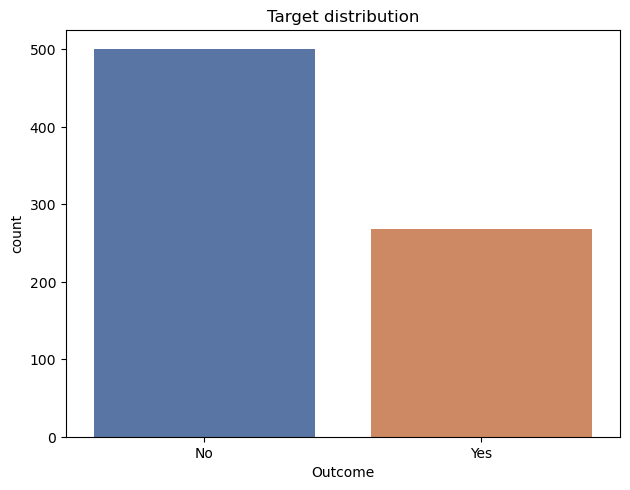

In [8]:
sns.countplot(data=dfdata, x='Outcome', palette='deep')
plt.tight_layout()
plt.title('Target distribution')
plt.xticks([0, 1], ['No', 'Yes']) 
plt.show()

In [9]:
diabetes_ratio = (dfdata['Outcome'].sum()/len(dfdata))*100
print(f'{diabetes_ratio:.2f}% of patients have diabetes')

34.90% of patients have diabetes


There are slight class imbalance in the target data

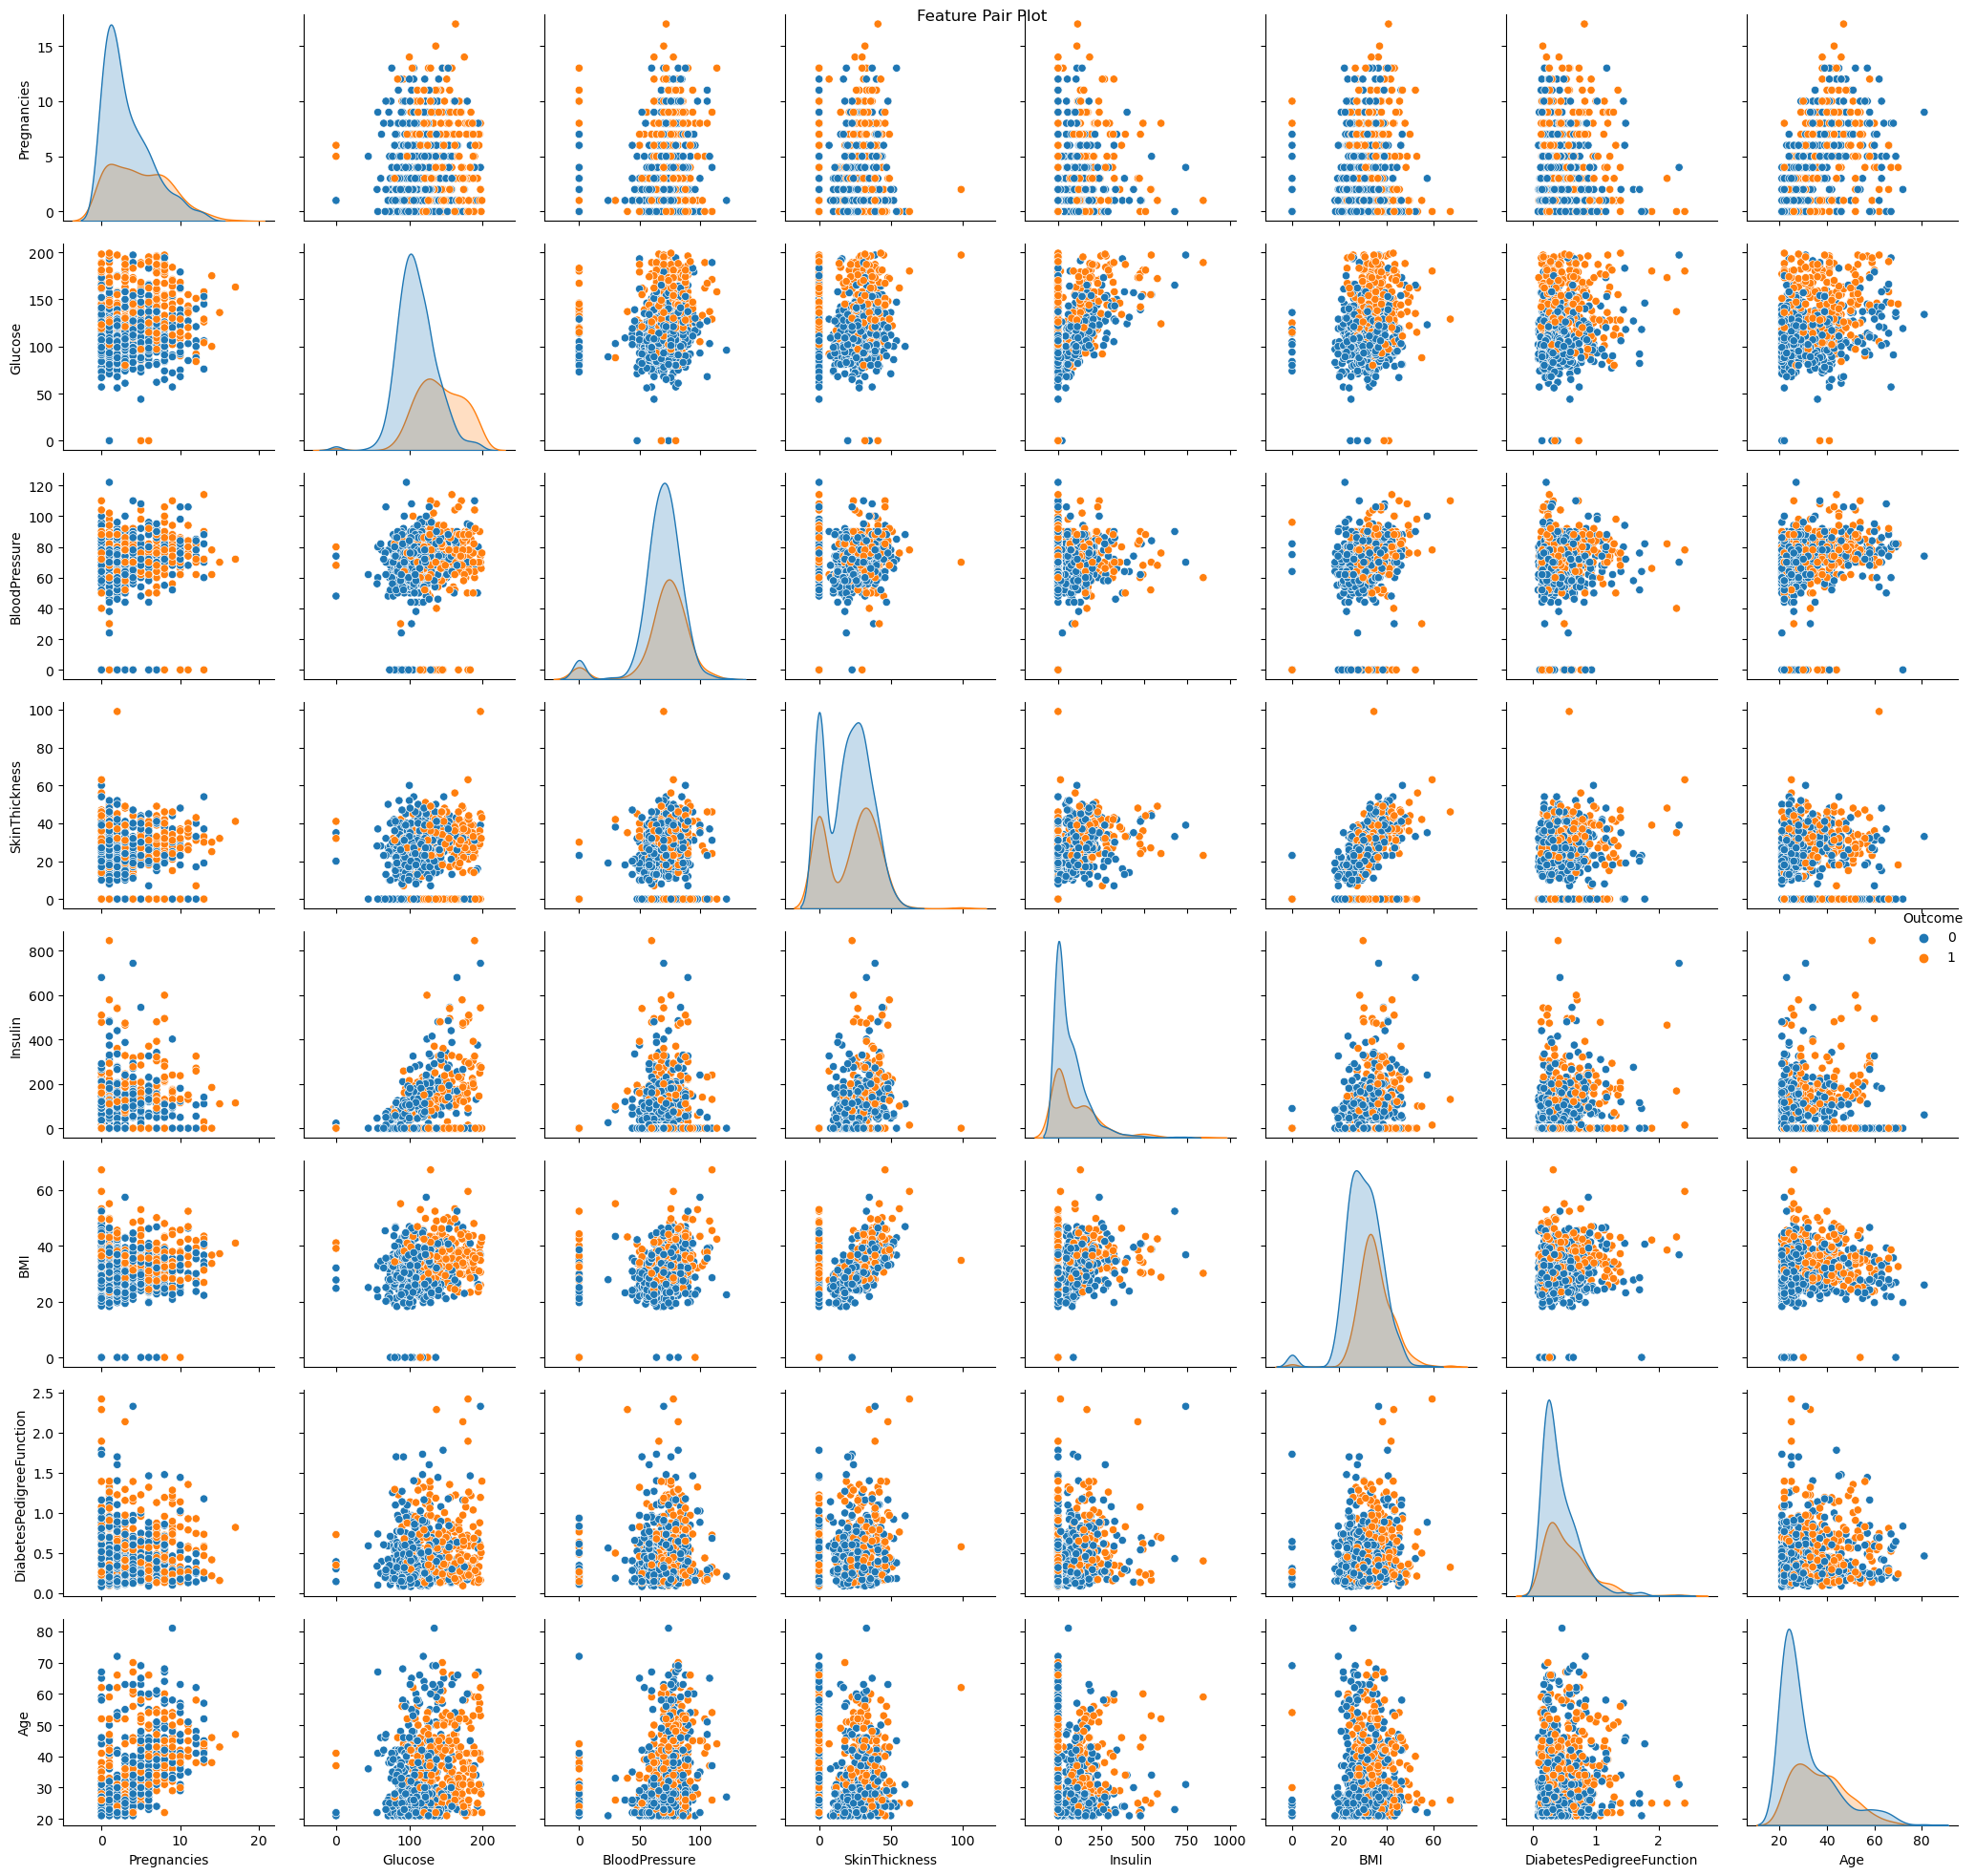

In [10]:
sns.pairplot(dfdata.drop('ID', axis=1),hue='Outcome')
plt.suptitle('Feature Pair Plot')
plt.tight_layout()
plt.show()

Notable insights :
1. Glucose is a great predictor with higher glucose indicates higher chance of diabetes.
2. Some entries have 0 values such as Glucose, BloodPressure, SkinThickness, Insulin, and BMI.
3. DiabetesPedigreeFunction (Pedi) and Insulin have clear outliers.

In [11]:
for col in feature_cols:
    zero_val = len(dfdata[dfdata[col]==0])
    print(f'There are {zero_val} zero value in {col}')

There are 111 zero value in Pregnancies
There are 5 zero value in Glucose
There are 35 zero value in BloodPressure
There are 227 zero value in SkinThickness
There are 374 zero value in Insulin
There are 11 zero value in BMI
There are 0 zero value in DiabetesPedigreeFunction
There are 0 zero value in Age


We will consider zero pregnancies as normal and the rest as bad columns

<Axes: >

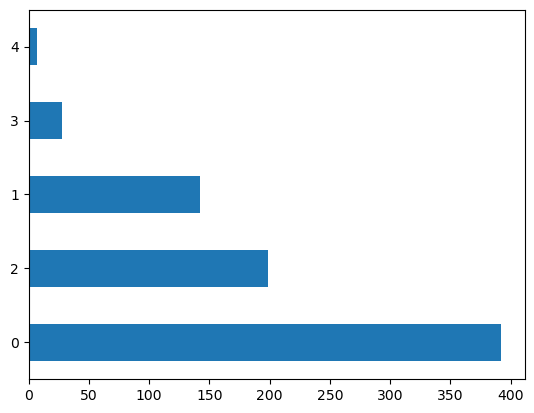

In [12]:
bad_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_count = dfdata[bad_cols].eq(0).sum(axis=1)
zero_count.value_counts().plot(kind='barh')

In [13]:
zero_count[zero_count>1].count()

234

There are 234 entries that have at least 2 zero values of selected features, we can drop them

In [14]:
dfdata = dfdata[zero_count<=1]
for col in bad_cols:
    zero_val = len(dfdata[dfdata[col]==0])
    print(f'There are {zero_val} zero value in {col}')

There are 1 zero value in Glucose
There are 0 zero value in BloodPressure
There are 0 zero value in SkinThickness
There are 140 zero value in Insulin
There are 1 zero value in BMI


In [15]:
diabetes_ratio = (dfdata['Outcome'].sum()/len(dfdata))*100
print(f'{diabetes_ratio:.2f}% of patients have diabetes')

33.15% of patients have diabetes


we can now impute mean for each of bad columns

In [16]:
for col in bad_cols:
    dfdata.loc[dfdata[col] == 0, col] = dfdata[col].mean()

In [17]:
for col in bad_cols:
    zero_val = len(dfdata[dfdata[col]==0])
    print(f'There are {zero_val} zero value in {col}')

There are 0 zero value in Glucose
There are 0 zero value in BloodPressure
There are 0 zero value in SkinThickness
There are 0 zero value in Insulin
There are 0 zero value in BMI


In [18]:
dfdata.head()

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148.0,72.0,35.0,114.76779,33.6,0.627,50,1
1,1,1,85.0,66.0,29.0,114.76779,26.6,0.351,31,0
3,3,1,89.0,66.0,23.0,94.00000,28.1,0.167,21,0
4,4,0,137.0,40.0,35.0,168.00000,43.1,2.288,33,1
6,6,3,78.0,50.0,32.0,88.00000,31.0,0.248,26,1


**Outlier Detection**

We will sue IsolationForest to detect outliers, we choose isolation forest because its easy to use and it can handle multiple features.

In [19]:
from sklearn.ensemble import IsolationForest

In [20]:
iso = IsolationForest(random_state=42, contamination=0.025)

iso_data = dfdata[feature_cols].values

_ = iso.fit(iso_data)

outliers = iso.predict(iso_data)

pd.Series(outliers).value_counts()

 1    520
-1     14
dtype: int64

The contamination parameters can be tuned to get the isolation capability needed.  
1 : Not Outliers  
-1 : Outliers

In [21]:
outlier_mask = outliers == 1
dfdata_clean = dfdata[outlier_mask]

In [22]:
diabetes_ratio = (dfdata_clean['Outcome'].sum()/len(dfdata_clean))*100
print(f'{diabetes_ratio:.2f}% of patients have diabetes')

32.12% of patients have diabetes


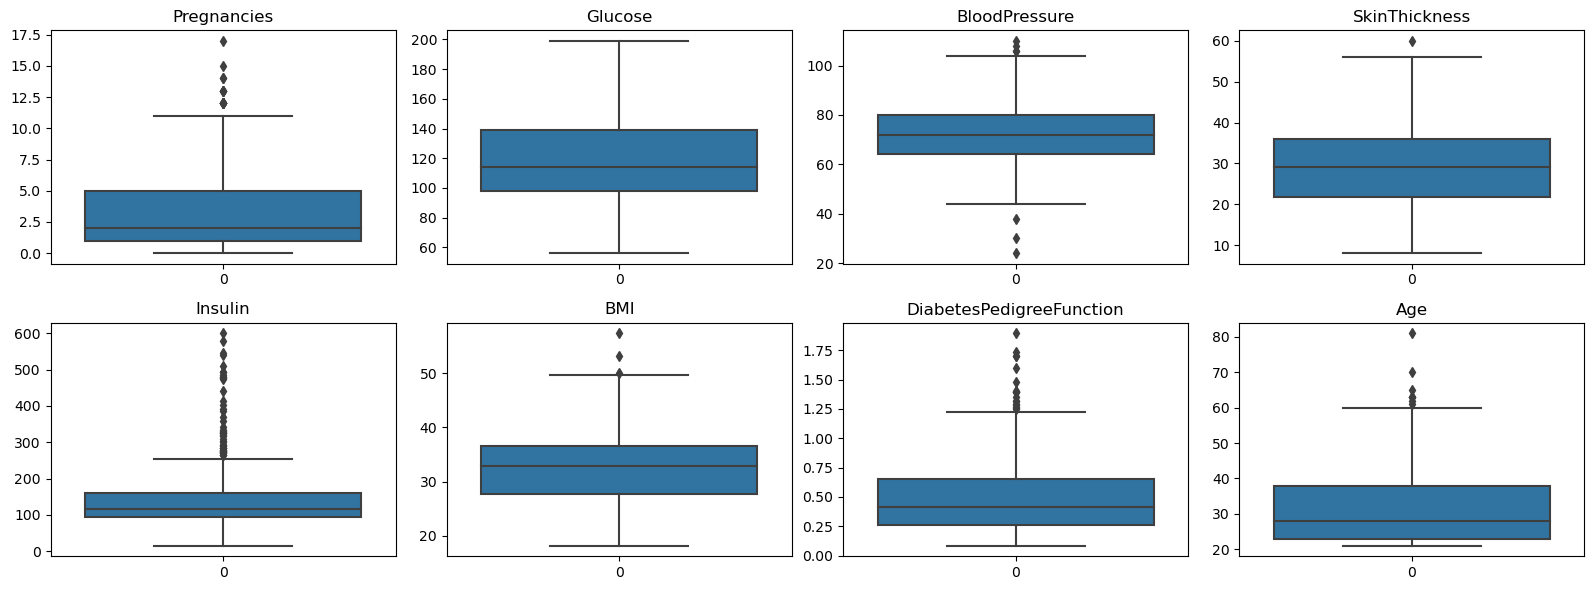

In [23]:
fig, axes = plt.subplots(2,4, figsize=(16,6))
for i,cols in enumerate(feature_cols):
    sns.boxplot(dfdata_clean[cols], ax=axes.flatten()[i])
    axes.flatten()[i].set_title(cols)

plt.tight_layout()
plt.show()

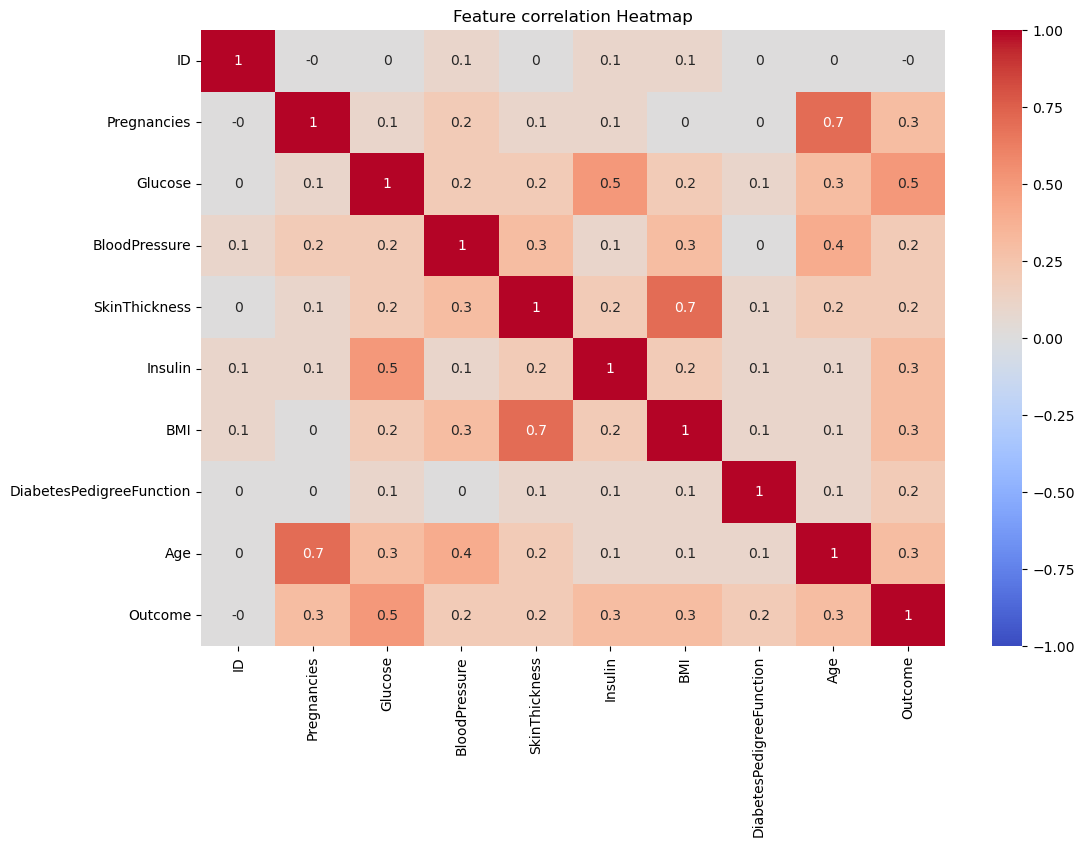

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(dfdata_clean.corr().round(1), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Feature correlation Heatmap')
plt.show()

### 2. Feature Engineering

In [39]:
def chi_squared_test(df, input_var, target_var, significance_level=0.3):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'1 | {input_var} has a significant relationship with the target variable.')
        return True 
    else:
        print(f'0 | {input_var} does not have a significant relationship with the target variable.')  
        return False 

We will use chi square tests to capture relationship between features and targets.  
we set the threshold quite large (0.3) to only drop features that are highly insignificant.

In [40]:
significant_cols = []
for feature in feature_cols:
    if chi_squared_test(dfdata, feature, 'Outcome'):
        significant_cols.append(feature)

print('')
print('Significant columns : ')
print(significant_cols)

1 | Pregnancies has a significant relationship with the target variable.
1 | Glucose has a significant relationship with the target variable.
1 | BloodPressure has a significant relationship with the target variable.
1 | SkinThickness has a significant relationship with the target variable.
1 | Insulin has a significant relationship with the target variable.
1 | BMI has a significant relationship with the target variable.
0 | DiabetesPedigreeFunction does not have a significant relationship with the target variable.
1 | Age has a significant relationship with the target variable.

Significant columns : 
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']


In this case, only Pedi does not have significant relationship to the target.

### 3. Modelling

In [27]:
X = dfdata_clean[significant_cols]
y = dfdata_clean['Outcome']

seed = 42
splits = 5
rskf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

We use StratifiedKFold to split the data into 5 sets of training validation fold.  
Stratified means that each fold maintains the same class distribution which is good for imbalanced data like ours.

In [28]:
def model_eval(model, cv = rskf, label = ''):
    X = dfdata_clean[significant_cols]
    y = dfdata_clean['Outcome']

    val_predictions = np.zeros((len(X)))
    train_scores, val_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        pipeline = Pipeline([
            ('Scaler', StandardScaler()), 
            ('Classifier', model)
        ])

        #define train set
        X_train = X.iloc[train_idx].values
        y_train = y.iloc[train_idx].values
        
        #define validation set
        X_val = X.iloc[val_idx].values
        y_val = y.iloc[val_idx].values

        pipeline.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        train_score = pipeline.score(X_train, y_train)
        val_score = pipeline.score(X_val, y_val)

        train_scores.append(train_score)
        val_scores.append(val_score)

        val_predictions[val_idx] += val_preds

    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    return val_scores, val_predictions


The evaluation model will evaluate each fold and calculate average validation and training error using simple accuracy metric.  
We will use 7 different models which are taught in the class as our base models and compare their performance.

In [29]:
models = [
    ('log', LogisticRegression(random_state = seed)),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('svc', SVC(random_state=seed, probability=True)),
    ('dt', DecisionTreeClassifier(random_state=seed))
]

In [30]:
score_list, pred_list = pd.DataFrame(), pd.DataFrame()

for (label, model) in models:
    score_list[label], pred_list[label] = model_eval(
        model,
        label = label
    )

Val Score: 0.77692 ± 0.02053 | Train Score: 0.77933 ± 0.00535 | log
Val Score: 0.75577 ± 0.01884 | Train Score: 0.76346 ± 0.00518 | gnb
Val Score: 0.72885 ± 0.02813 | Train Score: 0.72644 ± 0.00466 | bnb
Val Score: 0.76538 ± 0.02243 | Train Score: 0.82740 ± 0.01013 | knn
Val Score: 0.77115 ± 0.02537 | Train Score: 1.00000 ± 0.00000 | rf
Val Score: 0.77115 ± 0.01961 | Train Score: 0.82837 ± 0.00739 | svc
Val Score: 0.75192 ± 0.03817 | Train Score: 1.00000 ± 0.00000 | dt


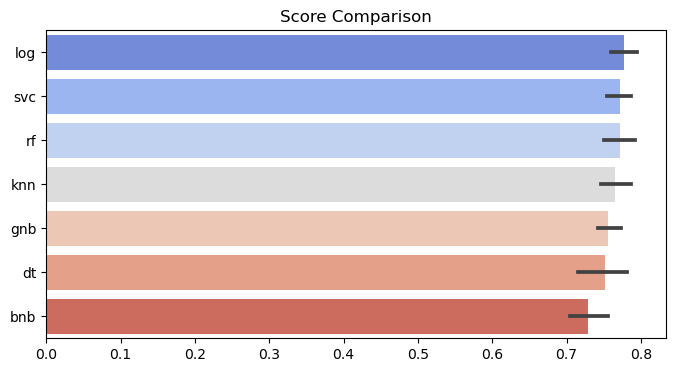

In [31]:
plt.figure(figsize = (8, 4))
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), palette = 'coolwarm', orient = 'h')
plt.title('Score Comparison')
plt.show()

We can see that Logistic Regression, Support Vector Classifier, and Random Forests Classifier performs better with accuracy over 77%. 

We will then create a more advanced model using ensemling and stacking.  
- **Ensembling** : We will use the output of each model to a voting mechanism so that each model can contribute to the overall output.
- **Stacking** : In stacking we will have another model called meta model which will have features and base model prediction as input to predict better predictions.

In [32]:
voter = VotingClassifier(models, voting = 'soft')
_, voter_preds = model_eval(voter, label='voter')

meta_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='logistic', solver='adam', learning_rate_init=0.001, max_iter=500, random_state=42)

stacker = StackingClassifier(models, final_estimator=meta_model, cv=5)
_, stacker_preds = model_eval(stacker, label='stacker')

Val Score: 0.78269 ± 0.03016 | Train Score: 0.88558 ± 0.00690 | voter
Val Score: 0.78269 ± 0.01783 | Train Score: 0.88510 ± 0.00905 | stacker


Both models have similiar validation and training score.

### 4. Model Evaluation

We will evaluate using validation set of a single train test split.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
voter_pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('Classifier', voter)
])

stacker_pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('Classifier', stacker)
])

In [35]:
_ = voter_pipeline.fit(X_train, y_train)
_ = stacker_pipeline.fit(X_train, y_train)

voter_pred = voter_pipeline.predict(X_test)
stacker_pred = stacker_pipeline.predict(X_test)

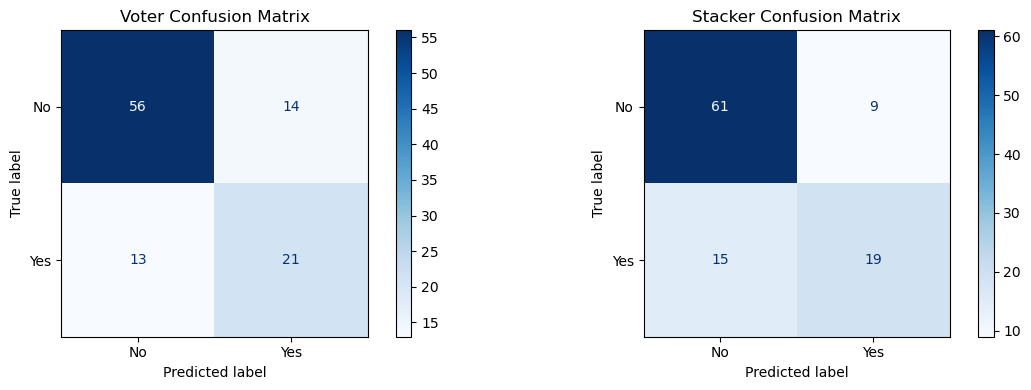

In [36]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
ConfusionMatrixDisplay.from_estimator(voter_pipeline, X_test, y_test, display_labels=['No', 'Yes'], cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Voter Confusion Matrix')

ConfusionMatrixDisplay.from_estimator(stacker_pipeline, X_test, y_test, display_labels=['No', 'Yes'], cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Stacker Confusion Matrix')

plt.tight_layout()
plt.show()

It is shown that Stacker models have better accuracy but more false negatives.

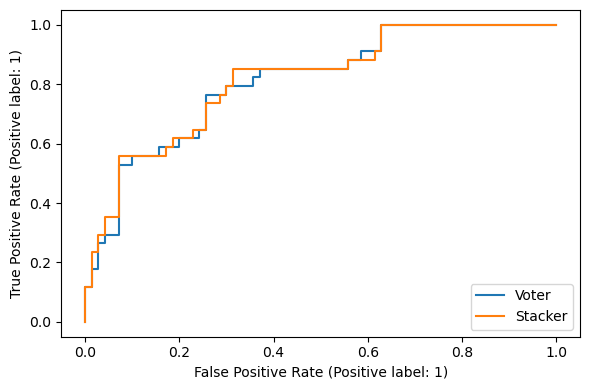

In [37]:
fig, axes = plt.subplots(figsize=(6,4))

RocCurveDisplay.from_estimator(voter_pipeline, X_test, y_test, ax=axes, label='Voter')
RocCurveDisplay.from_estimator(stacker_pipeline, X_test, y_test, ax=axes, label='Stacker')

plt.tight_layout()
plt.show()